In [1]:
import os
import time

import umap
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import MACA as maca

from scipy import io
from scipy.sparse import csr_matrix

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
##plot function
def plot_ann_umap(ad=None,ann=None):
    cluster_names = {}
    code, uniques = pd.factorize(ann)
    ad.obs['groups']=code.astype(str)
    for i in range(len(uniques)):
        cluster_names[str(i)]=str(i)+": "+uniques[i]

    ad.obs['Annotation'] = ad.obs['groups'].apply(lambda s: cluster_names[s])
    plt.figure(figsize=(8, 8))
    sc.pl.embedding(ad, basis='umap', color='Annotation', ax=plt.gca(), 
                    show=False)#, alpha=0.01#, size=10)

    df = pd.DataFrame(ad.obsm['X_umap'])
    df['cluster'] = ad.obs['groups'].values
    mean_pos = df.groupby('cluster').median()

    for c in mean_pos.index:    
        plt.gca().text(mean_pos.loc[c][0], mean_pos.loc[c][1], c.split(':')[0], 
                       fontsize=16, color='black')

    plt.title('Annotation')
    plt.show()

In [3]:
cell_markers={}

##Add PanglaoDB celltypes and markers
##Use PanglaoDB as marker database
##PanglaoDB available at https://panglaodb.se/index.html
pg_df = pd.read_table("MACA/PanglaoDB_markers_27_Mar_2020.tsv")
##remove mouse specific genes
pg_df = pg_df[pg_df['species']!='Mm']
for i in list(set(pg_df["cell type"].values.tolist())):
    genes = pg_df[pg_df["cell type"]==i]['official gene symbol'].values.tolist()
    ##only use cell type with at least 5 genes and less than 300 genes
    if len(genes)>=5 and len(genes)<=300:
        cell_markers[i]=genes


##human lung atlas markers
#markers_xls = pd.ExcelFile('Downloads/Atlas_markers/Lung/41586_2020_2922_MOESM6_ESM.xlsx')

#for cluster in markers_xls.sheet_names:
#    if 'SS2' not in cluster and 'SS' not in cluster:
#        markers = pd.read_excel(markers_xls, cluster,header=None,index_col=False)
#        celltype = markers.iloc[0,0]
#        markers = pd.read_excel(markers_xls, cluster,header=1,index_col=0)
#        markers = markers[markers['avg_logFC'].values>=1]
#        markers = markers[markers['pct_in_cluster'].values>=0.8]
#        markers = markers[markers['pct_out_cluster'].values<0.5]
#        markers = markers.index.tolist()
#        if len(markers)>=5 and len(markers)<=300:
#            cell_markers[celltype]=markers
        
###human kidney atlas markers
#markers_dir = "Downloads/Atlas_markers/Kidney/"
#files = os.listdir(markers_dir)

#for f in files:
#    markers = pd.read_csv(markers_dir+f,index_col=0, header=1)
#    logFold = np.log((markers['geneExpression'].values+1)/(markers['geneExpressionOutsideCluster'].values+1))
#    markers = markers[logFold>=1]
#    markers = markers[markers['geneFrequency'].values>=0.8]
#    markers = markers[markers['geneFrequencyOutsideCluster'].values<0.5]
#    celltypes = markers['Cell.type'].values.tolist()
#    celltypes = list(set(celltypes))
#    for c in celltypes:
#        sub_markers = markers[markers['Cell.type'].values==c]
#        m = sub_markers['Gene'].values.tolist()
#        if len(m)>=5 and len(m)<=300:
#            cell_markers[c]=m

In [19]:
genes = pd.read_table("Documents/DingPBMC/GSE132044_pbmc_hg38_gene.tsv.gz",header=None,index_col=False)
metadata = pd.read_csv("Documents/DingPBMC/GSE132044_pbmc_hg38_cell.tsv.gz",header=None,index_col=False)
metadata=metadata[0].str.split('.',expand=True)
metadata.columns = ['Sample','Tech','Index']
genes=genes[0].str.split('_',expand=True)
genes = genes.iloc[:,:2]
genes.columns = ['ENSG','Gene']

In [20]:
data = "Documents/DingPBMC/GSE132044_pbmc_hg38_count_matrix.mtx.gz"
data = io.mmread(data)
data = csr_matrix(data)
data = pd.DataFrame(data.todense())
data.index = genes['Gene'].values
data=data.loc[~data.index.duplicated(keep='first')]
data = data.sort_index()
data = data.T

Trying to set attribute `.obs` of view, copying.


(44615, 168)
(44615, 168)


... storing 'Sample' as categorical
... storing 'Tech' as categorical


--- 5 mins ---


... storing 'Index' as categorical
... storing 'Annotation' as categorical


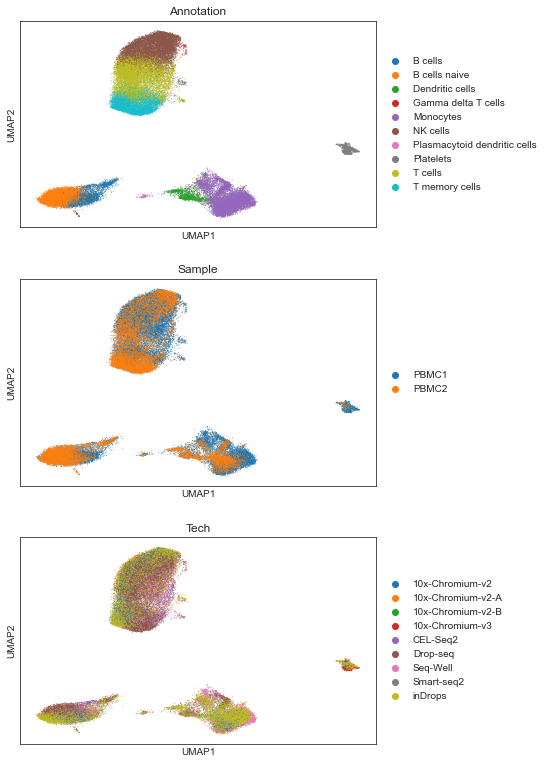

In [21]:
adata = anndata.AnnData(X=data,obs=metadata)
adata.var.index = data.columns
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)

ad = adata[:,marker_list]
ad.X.shape

##run MACA
start_time = time.time()
ad, annotation = maca.singleMACA(ad=ad, cell_markers=cell_markers,
                                 res=[1,2,3],n_neis=[3,5,10])
print("--- %s mins ---" % int((time.time() - start_time)/60))

##visualization
adata.obs['Annotation']=annotation
adata.obsm['X_umap']=ad.obsm['X_umap']

sc.pl.umap(adata, color=["Annotation","Sample","Tech"],ncols=1,save='MACA_Ding')

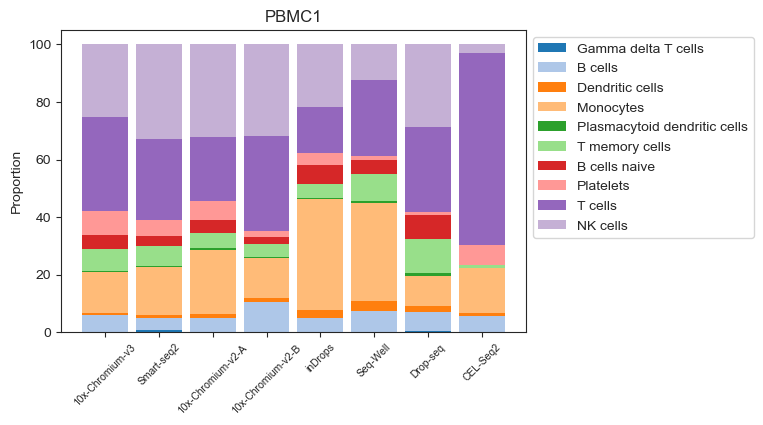

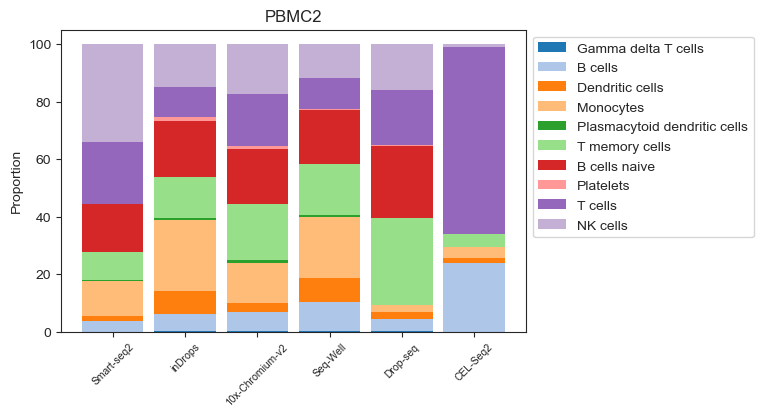

In [25]:
pbmc1 = adata[adata.obs['Sample']=='PBMC1']
patients = list(set(pbmc1.obs['Tech']))
celltypes = list(set(pbmc1.obs['Annotation']))
#celltypes = list(set(adata.obs['CellType']))
ad_coda_pd = np.zeros((len(patients),len(celltypes)+1))
for p in range(len(patients)):
    subad = pbmc1[pbmc1.obs['Tech']==patients[p]]
    for i in range(len(celltypes)):
        subcell = subad[subad.obs['Annotation']==celltypes[i]]
        ad_coda_pd[p,i]=subcell.X.shape[0]
        
ad_coda_pd = pd.DataFrame(ad_coda_pd)
celltypes.append('PBMC1')
ad_coda_pd.columns = celltypes
ad_coda_pd.iloc[:,-1]=patients
ad_coda = dat.from_pandas(ad_coda_pd, covariate_columns=["PBMC1"])

viz.stacked_barplot(ad_coda, feature_name="PBMC1")
plt.xticks(fontsize=7.5)
#plt.show()
plt.savefig('MACA_PBMC1_Ding.pdf',dpi=450)

pbmc1 = adata[adata.obs['Sample']=='PBMC2']
patients = list(set(pbmc1.obs['Tech']))
celltypes = list(set(pbmc1.obs['Annotation']))
#celltypes = list(set(adata.obs['CellType']))
ad_coda_pd = np.zeros((len(patients),len(celltypes)+1))
for p in range(len(patients)):
    subad = pbmc1[pbmc1.obs['Tech']==patients[p]]
    for i in range(len(celltypes)):
        subcell = subad[subad.obs['Annotation']==celltypes[i]]
        ad_coda_pd[p,i]=subcell.X.shape[0]
        
ad_coda_pd = pd.DataFrame(ad_coda_pd)
celltypes.append('PBMC2')
ad_coda_pd.columns = celltypes
ad_coda_pd.iloc[:,-1]=patients
ad_coda = dat.from_pandas(ad_coda_pd, covariate_columns=["PBMC2"])

viz.stacked_barplot(ad_coda, feature_name="PBMC2")
plt.xticks(fontsize=7.5)
#plt.show()
plt.savefig('MACA_PBMC2_Ding.pdf',dpi=450)